**Imports**

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim

**Data Processing**

In [ ]:
CODING_SIZE = 100
BATCH_SIZE = 32
IMAGE_SIZE = 64

device = torch.device("cuda:0" if
torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
transforms.Resize(IMAGE_SIZE),
transforms. ToTensor(),
])
dataset = datasets.FashionMNIST(
                '/',
                train=True,
                download=True,
                transform=transform)

dataloader = DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=8)



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Displaying a batch of images**

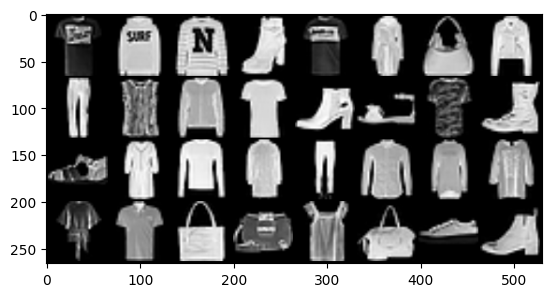

In [ ]:
data_batch, labels_batch = next(iter(dataloader))
grid_img = make_grid(data_batch, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))



**Generator**

In [ ]:
class Generator(nn.Module):
  def __init__(self, coding_sz):
      super(Generator,self).__init__()
      self.net= nn.Sequential(
          nn.ConvTranspose2d(coding_sz,1024,4,1,0),
          nn.BatchNorm2d(1024),
          nn.ReLU(),
          nn.ConvTranspose2d(1024,512,4,2,1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.ConvTranspose2d(512,256,4,2,1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.ConvTranspose2d(256,128,4,2,1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.ConvTranspose2d(128,1,4,2,1),
          nn.Tanh()
      )
  def forward(self, input):
    return self.net(input)

In [ ]:
netG = Generator(CODING_SIZE).to(device)



**Discriminator**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator,self).__init__()
      self.net= nn.Sequential(
          nn.Conv2d(1,128,4,2,1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(128,256,4,2,1),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2),
          nn.Conv2d(256,512,4,2,1),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2),
          nn.Conv2d(512,1024,4,2,1),
          nn.BatchNorm2d(1024),
          nn.LeakyReLU(0.2),
          nn.Conv2d(1024,1,4,1,0),
          nn.Sigmoid()
      )
  def forward(self, input):
    return self.net(input)

In [ ]:
netD = Discriminator().to(device)



**Initializing weights**

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:

    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)



In [ ]:
netG.apply(weights_init)
netD.apply(weights_init)



Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

**Defining loss function and optimizer**

In [ ]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(),
                        lr=0.0002,
                        betas=(0.5, 0.999))

optimizerD = optim.Adam(netD.parameters(),
                        lr=0.0001,
                        betas=(0.5, 0.999))



**Defining values for real and fake labels**

In [ ]:
real_labels = torch.full((BATCH_SIZE,),
                       1.,
                       dtype=torch.float,
                       device=device)



fake_labels = torch.full((BATCH_SIZE,),
                       0.,
                       dtype=torch.float,
                       device=device)



**Training**

In [ ]:
G_losses = []

D_losses = []
D_real = []
D_fake = []

z = torch.randn((
    BATCH_SIZE, 100)).view(-1, 100, 1, 1).to(device)
test_out_images = []


N_EPOCHS = 5 

for epoch in range(N_EPOCHS):
  print(f'Epoch: {epoch}')
  for i, batch in enumerate(dataloader):
    if (i%200==0):
      print(f'batch: {i} of {len(dataloader)}')

    # Train Discriminator with an all-real batch.
    netD.zero_grad()

    real_images = batch[0].to(device) *2. - 1.
    output = netD(real_images).view(-1)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()

   # Train Discriminator with an all-fake batch
    noise = torch.randn((BATCH_SIZE,
                         CODING_SIZE))
    noise = noise.view(-1,100,1,1).to(device)
    fake_images = netG(noise)
    output = netD(fake_images).view(-1) 
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    errD.backward(retain_graph=True) 
    optimizerD.step()

    # Train Generator to generate better fakes.
    netG.zero_grad()

    output = netD(fake_images).view(-1) 
    errG = criterion(output, real_labels) 
    errG.backward()

    D_G_z2 = output.mean().item()
    optimizerG.step()
    # Save losses for plotting later.
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    D_real.append(D_x)
    D_fake.append(D_G_z2)
    test_images = netG(z).to('cpu').detach()
    test_out_images.append(test_images)







Epoch: 0
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 1
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 2
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 3
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 4
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 180

**Generated images after the first epoch**

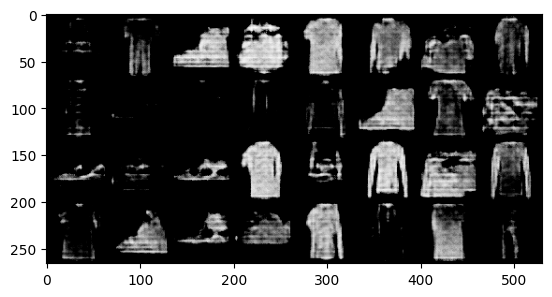

In [ ]:
grid_img3 = make_grid(test_out_images[1874], nrow=8)
plt.imshow(grid_img3.permute(1, 2, 0))

**Generated images after the last epoch**

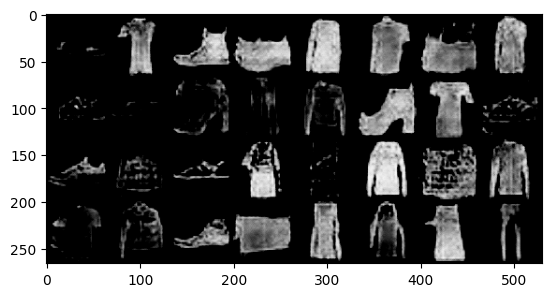

In [ ]:
grid_img3 = make_grid(test_out_images[9374], nrow=8)
plt.imshow(grid_img3.permute(1, 2, 0))

**The generator loss curve**

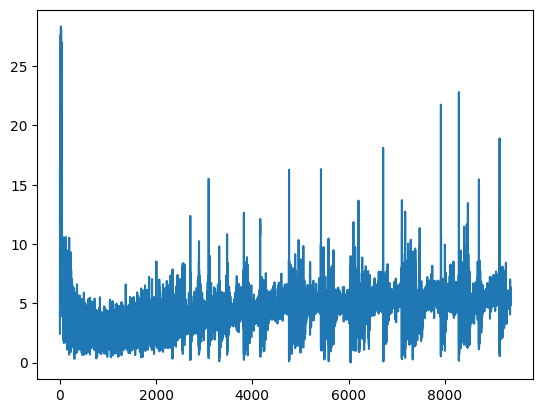

In [ ]:
plt.plot(G_losses)
plt.show()

**The discriminator loss curve**

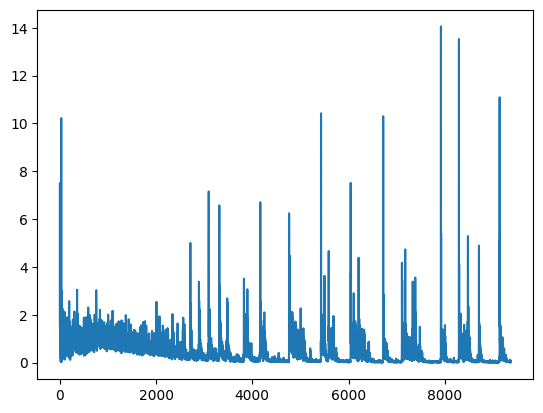

In [ ]:
plt.plot(D_losses)
plt.show()

**The average results of the discriminator**

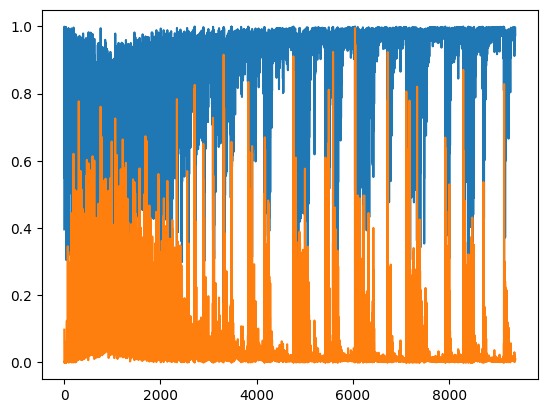

In [ ]:
plt.plot(D_real)
plt.plot(D_fake)
plt.show()

**Saving the model**

In [ ]:
torch.save(netG.state_dict(), './gan.pt')

